In [1]:
import os
import sys
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
INPUT_DIR = "../inputs"
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
# sample_submit.csvにはカラム名がないのでnames=("id","target")でカラム名をつくってやる
submit_df = pd.read_csv(os.path.join(INPUT_DIR, "sample_submit.csv"),names=("id","target"))

In [3]:
# カラム名が日本語なのは不都合なので英語に変換する
train_df = train_df.rename(
    columns={
        '賃料':'target',
        '契約期間':'Contract', 
        '間取り':'Room', 
        '築年数':'Passed',
        '駐車場':'Parking', 
        '室内設備':'Facility', 
        '放送・通信':'Internet', 
        '周辺環境':'Building', 
        '建物構造':'Material', 
        '面積':'Area', 
        'キッチン':'Kitchen', 
        '所在地':'Place',
        'バス・トイレ':'Bath', 
        '所在階':'Floor', 
        'アクセス':'Access', 
        '方角':'Angle'
    }
)

test_df = test_df.rename(
    columns={
        '契約期間':'Contract', 
        '間取り':'Room', 
        '築年数':'Passed',
        '駐車場':'Parking', 
        '室内設備':'Facility', 
        '放送・通信':'Internet', 
        '周辺環境':'Building', 
        '建物構造':'Material', 
        '面積':'Area', 
        'キッチン':'Kitchen', 
        '所在地':'Place',
        'バス・トイレ':'Bath', 
        '所在階':'Floor', 
        'アクセス':'Access', 
        '方角':'Angle'
    }
)

### 前処理
前処理はtrainとtestに対して同じ処理をしないといけないので、trainとtestをconcatして、それに対して前処理してから再度trainとtestに戻す

In [4]:
train_df["train_or_test"] = "train"
test_df["train_or_test"] = "test"
concat_df = pd.concat([train_df, test_df], axis=0)
display(concat_df.head(1))
print(concat_df.columns)

,id,target,Place,Access,Room,Passed,Angle,Area,Floor,Bath,Kitchen,Internet,Facility,Parking,Building,Material,Contract,train_or_test
0,1,75000.0,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間,train


Index(['id', 'target', 'Place', 'Access', 'Room', 'Passed', 'Angle', 'Area',
       'Floor', 'Bath', 'Kitchen', 'Internet', 'Facility', 'Parking',
       'Building', 'Material', 'Contract', 'train_or_test'],
      dtype='object')


In [5]:
columns = [
    "target",
    "Place",
    "Room",
    "Passed",
    "Angle",
    "Area",
    "Floor",
    "Contract"
]
feat_df = concat_df[columns].copy()
feat_df

,target,Place,Room,Passed,Angle,Area,Floor,Contract
0,75000.0,東京都北区滝野川３丁目,1K,9年9ヶ月,南東,20.01m2,1階／12階建,2年間
1,76000.0,東京都中央区月島３丁目,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,2年間
2,110000.0,東京都渋谷区笹塚２丁目,1K,8年6ヶ月,南,22.05m2,12階／15階建,2年間
3,150000.0,東京都杉並区高円寺南２丁目23-2,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,2年間\t※この物件は\t定期借家\tです。
4,74000.0,東京都葛飾区金町３丁目7-2,2DK,31年7ヶ月,南,39.66m2,1階／2階建,2年間
...,...,...,...,...,...,...,...,...
31257,NaN,東京都豊島区上池袋４丁目,1K,0年1ヶ月,東,25.66m2,6階／8階建,2年間
31258,NaN,東京都千代田区岩本町２丁目,1R,15年6ヶ月,南,22.71m2,8階／15階建,NaN
31259,NaN,東京都中野区江古田３丁目14-3,1LDK,1年0ヶ月,南東,45.76m2,10階／14階建,2年間\t※この物件は\t定期借家\tです。
31260,NaN,東京都千代田区二番町,1K,15年4ヶ月,北,55.2m2,14階／14階建,NaN


### 特徴量の種類
- 連続変数
- カテゴリ変数
    - One hot Encoding
    - Label Encoding

In [6]:
# label encoding
from sklearn.preprocessing import LabelEncoder

# label encodingしたい変数を抜き出す
feat_col = [c for c in feat_df.columns if c not in ["target","Area"]]
# 前処理後の特徴量を格納するdataframeを宣言する
feat2_df = feat_df[["target"]].copy()
feat2_df["Area"] = feat_df["Area"].apply(lambda x: np.float(x[:-2]))
print(feat_col)
for col in feat_col:
    le = LabelEncoder()
    feat2_df[col] = le.fit_transform(feat_df[col])#.reshape(-1,1)

display(feat2_df)

['Place', 'Room', 'Passed', 'Angle', 'Floor', 'Contract']


,target,Area,Place,Room,Passed,Angle,Floor,Contract
0,75000.0,20.01,3224,3,769,4,421,58
1,76000.0,16.50,2215,9,460,8,1024,58
2,110000.0,22.05,11534,3,754,3,108,58
3,150000.0,60.48,8798,14,261,3,872,59
4,74000.0,39.66,15221,10,300,3,436,58
...,...,...,...,...,...,...,...,...
31257,NaN,25.66,15413,3,3,6,1159,58
31258,NaN,22.71,3548,9,83,3,1242,79
31259,NaN,45.76,2854,5,135,4,10,59
31260,NaN,55.20,3492,3,81,0,190,79


In [7]:
feat2_df = pd.concat([feat2_df, concat_df["train_or_test"]], axis=1)
feat2_df

,target,Area,Place,Room,Passed,Angle,Floor,Contract,train_or_test
0,75000.0,20.01,3224,3,769,4,421,58,train
1,76000.0,16.50,2215,9,460,8,1024,58,train
2,110000.0,22.05,11534,3,754,3,108,58,train
3,150000.0,60.48,8798,14,261,3,872,59,train
4,74000.0,39.66,15221,10,300,3,436,58,train
...,...,...,...,...,...,...,...,...,...
31257,NaN,25.66,15413,3,3,6,1159,58,test
31258,NaN,22.71,3548,9,83,3,1242,79,test
31259,NaN,45.76,2854,5,135,4,10,59,test
31260,NaN,55.20,3492,3,81,0,190,79,test


In [8]:
train = feat2_df[feat2_df["train_or_test"]=="train"].drop("train_or_test", axis=1)
test = feat2_df[feat2_df["train_or_test"]=="test"].drop(["train_or_test","target"], axis=1)
display(train)
display(test)

,target,Area,Place,Room,Passed,Angle,Floor,Contract
0,75000.0,20.01,3224,3,769,4,421,58
1,76000.0,16.50,2215,9,460,8,1024,58
2,110000.0,22.05,11534,3,754,3,108,58
3,150000.0,60.48,8798,14,261,3,872,59
4,74000.0,39.66,15221,10,300,3,436,58
...,...,...,...,...,...,...,...,...
31465,80000.0,37.90,9506,10,279,3,439,58
31466,54500.0,12.04,785,9,396,7,994,58
31467,125000.0,60.00,10629,17,472,3,881,58
31468,98000.0,29.59,2534,1,27,3,436,58


,Area,Place,Room,Passed,Angle,Floor,Contract
0,50.22,1238,14,519,3,1286,79
1,20.88,12536,9,4,4,872,58
2,26.93,15693,3,189,4,443,58
3,23.57,8110,3,355,4,436,58
4,50.00,8210,14,477,3,994,58
...,...,...,...,...,...,...,...
31257,25.66,15413,3,3,6,1159,58
31258,22.71,3548,9,83,3,1242,79
31259,45.76,2854,5,135,4,10,59
31260,55.20,3492,3,81,0,190,79


### 最寄駅から徒歩何分かの特徴量を追加

In [9]:
def extract_minute(x):
    ans = [int(s.replace("徒歩","").replace("分","")) for s in x.split("\t") if "徒歩"==s[:2]]
    try:
        ans = min(ans)
    except:
        ans = np.nan
    return ans
# train
access = pd.DataFrame(train_df["Access"].apply(extract_minute)).rename(columns={"Access":"nearest_time"})
train = pd.concat([train, access],axis=1)
# test
access = pd.DataFrame(test_df["Access"].apply(extract_minute)).rename(columns={"Access":"nearest_time"})
test = pd.concat([test, access],axis=1)

In [10]:
# 学習データを特徴量とtargetに分ける
train_X = train.drop("target", axis=1).copy()
train_y = train["target"]

test_X = test.copy()

### 学習
- trainデータで学習して、testデータに対して予測・推論する
- train
    - 学習用(train)
    - 評価（validation）
    - train:validation = 4:1
    - trainとvaldationの分ける手法はcross validationと言う
        - Kfold
        - Stratified Kfold

    - 今回はkfoldを使う

In [11]:
class Config:
    n_splits = 3
    seed = 46
    lgbm_params = {
        "objective": "rmse",
        "verbose":-1,
        "random_state":seed,
        "learning_rate": 1e-1,
        # L2 Reguralization
        "reg_lambda": .1,
        # こちらは L1 
        "reg_alpha": 0,
        # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
        "max_depth": 8, 
        # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
        "n_estimators": 10000, 
        # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
        "colsample_bytree": .5, 
        # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
        "min_child_samples": 10,
        # bagging の頻度と割合
        "subsample_freq": 3,
        "subsample": .9,
        # 特徴重要度計算のロジック
        "importance_type": "gain", 
        }
    early_stopping = 100

cfg = Config

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

models = []
rmse_folds = []
oof = []
kf = KFold(n_splits=cfg.n_splits) # n_splits=3
for i, (train_index, valid_index) in enumerate(kf.split(train_X.values)):
    print(f"============= Fold {i} =============")
    # indexでtrainを学習用データと評価用データに分ける
    tr_X, tr_y = train_X.loc[train_index], train_y.loc[train_index]
    val_X, val_y = train_X.loc[valid_index], train_y.loc[valid_index]

    # 学習モデルの初期化
    model = lgb.LGBMRegressor(**cfg.lgbm_params)

    # 学習
    model.fit(
        tr_X,
        tr_y,
        eval_set=[(val_X, val_y)],
        early_stopping_rounds=cfg.early_stopping,
        verbose=-1
        )

    # 学習済みモデルを格納
    models.append(model)
    # 予測
    preds = model.predict(val_X)

    rmse = np.sqrt(mean_squared_error(val_y, preds))
    rmse_folds.append(rmse)
    print(f"rmse {rmse}")
    oof.append(preds)
print(f" cv score {np.mean(rmse_folds)}")

============= Fold 0 =============
rmse 25786.63956794655
============= Fold 1 =============
rmse 20976.336157514277
============= Fold 2 =============
rmse 18629.61605572676
 cv score 21797.530593729196


In [13]:
test_preds = []
for model in models:
    pred = model.predict(test_X)
    print(pred)
    test_preds.append(pred)

np.mean(test_preds, axis=0)

[156569.44368492 125327.52038044  78969.8683872  ... 186969.6830755
 272452.01504018  82373.91015416]
[129558.71034651 122605.15739331  80270.89502798 ... 179034.64614575
 261568.76187936  78096.76637609]
[129092.38272664 124252.95667128  76083.88697897 ... 184747.29893862
 267867.72543612  77969.30640858]


array([138406.84558602, 124061.87814835,  78441.55013138, ...,
       183583.87605329, 267296.16745189,  79479.99431295])

### 提出用予測ファイルの作成

In [14]:
test_preds = []
for model in models:
    pred = model.predict(test_X)
    test_preds.append(pred)

test_preds = np.mean(test_preds, axis=0)
submit_df["target"] = test_preds
os.makedirs("../outputs", exist_ok=True)
submit_df.to_csv("../outputs/lgbm_sub02.csv", index=False, header=None)

### 特徴重要度

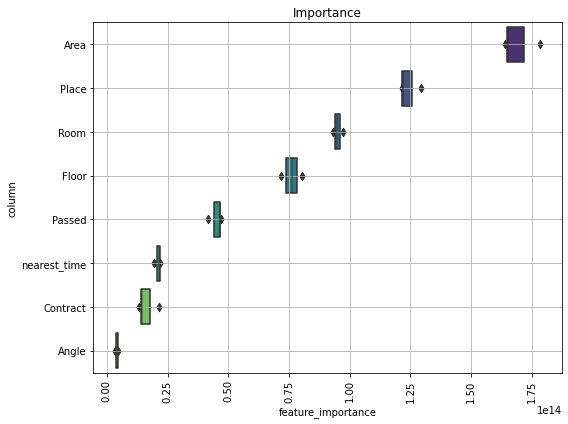

In [15]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:100]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax
#import japanize_matplotlib
fig, ax = visualize_importance(models, train_X)

### ここからRMSEを下げるには
- 特徴量を増やす（まだつかってないやつとか）
- モデルを変える
    - 今回はLightGBM（勾配Boosting決定木(GBDT)）
    - 他のGBDT
        - XgBoost
        - CatBoost
    - Deep Neural Network(pytorch使うといい)
    - scikit-learnに実装されているモデル
        - random forest
        - support vector machine
- 複数のモデルを学習させてアンサンブル